In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import re

df =pd.read_csv('../../data/options_additions_removals.csv')
df['removed'] = df['commit_date_removed'].notna()
df_removed = df[df['removed']]
print(df_removed.head())

    Unnamed: 0                 variable      toggle_type  \
0            0  3p-intents-in-incognito          UI Flag   
8            8        AOMAriaProperties  Runtime Feature   
11          11                AOMPhase1  Runtime Feature   
12          12           AbortSignalAny  Runtime Feature   
13          13   AbortSignalComposition  Runtime Feature   

            commit_date_added                           commit_id_added  \
0   2022-05-30 14:28:57+00:00  d7546ae7a656ca9919c5cac50409222a87c24e49   
8   2019-10-25 04:08:32+00:00  c981cf9e41c4161516081d44a7a8944aab77ba97   
11  2019-08-28 06:33:47+00:00  99db9a12afd13c2a6ad637f6dd69d550570e870a   
12  2023-01-06 16:48:35+00:00  993f6cc1569f96df1fd32c67c1251b992dfd61b9   
13  2023-03-10 06:49:02+00:00  c25f49cfdebeb688bd3734d3cb8c6a0a308c4d70   

                                 commit_message_added  \
0   Author: Quentin Pubert <qpubert@google.com> [i...   
8   Author: Rakina Zata Amni <rakina@chromium.org>...   
11  Author: Mered

In [12]:
history =pd.read_csv('../../data/efforts_all_commits.csv', header=None)

history.columns=['commit', 
                 'changedFiles', 
                 'additions', 
                 'removals']
merged = df.merge(history, left_on='commit_id_removed', right_on='commit', how='inner')


In [13]:
removal_commits = merged['commit']
history_non_toggle = history[~history['commit'].isin(removal_commits)].copy()
history_non_toggle['toggle_type'] = 'Ordinary changes'

In [ ]:
# Ensure relevant columns are numeric
for col in ['changedFiles', 'additions', 'removals']:
    merged[col] = pd.to_numeric(merged[col], errors='coerce')

merged['ratio'] = merged['removals']/merged['changedFiles']

# Compute global statistics
effort_stats = {
    "changedFiles": {
        "mean": merged["changedFiles"].mean(),
        "median": merged["changedFiles"].median(),
        "min": merged["changedFiles"].min(),
        "max": merged["changedFiles"].max(),
    },
    "additions": {
        "mean": merged["additions"].mean(),
        "median": merged["additions"].median(),
        "min": merged["additions"].min(),
        "max": merged["additions"].max(),
    },
    "removals": {
        "mean": merged["removals"].mean(),
        "median": merged["removals"].median(),
        "min": merged["removals"].min(),
        "max": merged["removals"].max(),
    }, 
    "ratio": {
        "mean": merged["ratio"].mean(),
        "median": merged["ratio"].median(),
        "min": merged["ratio"].min(),
        "max": merged["ratio"].max(),
    }
}

# Group by toggle type and compute effort stats per type
effort_stats_per_type = merged.groupby('toggle_type').agg({
    'changedFiles': ['mean', 'median', 'min', 'max'],
    'additions': ['mean', 'median', 'min', 'max'],
    'removals': ['mean', 'median', 'min', 'max']
})

# Flatten MultiIndex columns for readability
effort_stats_per_type.columns = ['_'.join(col).strip() for col in effort_stats_per_type.columns.values]

# Display results
import pprint
pprint.pprint(effort_stats)

effort_stats_per_type


print('history non-toggles:')

# Ensure relevant columns are numeric
for col in ['changedFiles', 'additions', 'removals']:
    history_non_toggle[col] = pd.to_numeric(history_non_toggle[col], errors='coerce')

# Compute global statistics
effort_non_toggles_stats = {
    "changedFiles": {
        "mean": history_non_toggle["changedFiles"].mean(),
        "median": history_non_toggle["changedFiles"].median(),
        "min": history_non_toggle["changedFiles"].min(),
        "max": history_non_toggle["changedFiles"].max(),
    },
    "additions": {
        "mean": history_non_toggle["additions"].mean(),
        "median": history_non_toggle["additions"].median(),
        "min": history_non_toggle["additions"].min(),
        "max": history_non_toggle["additions"].max(),
    },
    "removals": {
        "mean": history_non_toggle["removals"].mean(),
        "median": history_non_toggle["removals"].median(),
        "min": history_non_toggle["removals"].min(),
        "max": history_non_toggle["removals"].max(),
    }
}

pprint.pprint(effort_non_toggles_stats)

{'additions': {'max': 23054,
               'mean': 53.55280600972161,
               'median': 6.0,
               'min': 0},
 'changedFiles': {'max': 27550,
                  'mean': 20.57769921932538,
                  'median': 8.0,
                  'min': 1},
 'ratio': {'max': 1266.857142857143,
           'mean': 21.45505237383913,
           'median': 6.875,
           'min': 0.1},
 'removals': {'max': 7258294,
              'mean': 1364.4144940344675,
              'median': 59.0,
              'min': 1}}
history non-toggles:
{'additions': {'max': 4599043,
               'mean': 166.67691625942402,
               'median': 14.0,
               'min': 0},
 'changedFiles': {'max': 141868,
                  'mean': 8.252957077668484,
                  'median': 2.0,
                  'min': 0},
 'removals': {'max': 4599046,
              'mean': 128.16446272685505,
              'median': 4.0,
              'min': 0}}


In [15]:
combined = pd.concat([merged, history_non_toggle], ignore_index=True)
combined['group'] = combined['toggle_type'].apply(lambda x: 'Ordinary changes' if x == 'Ordinary changes' else 'Toggle Removal')

print(len(history_non_toggle))

1532256


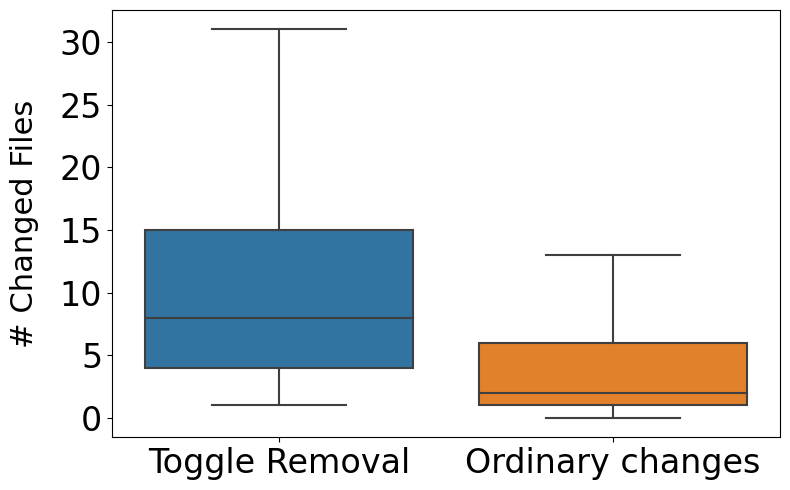

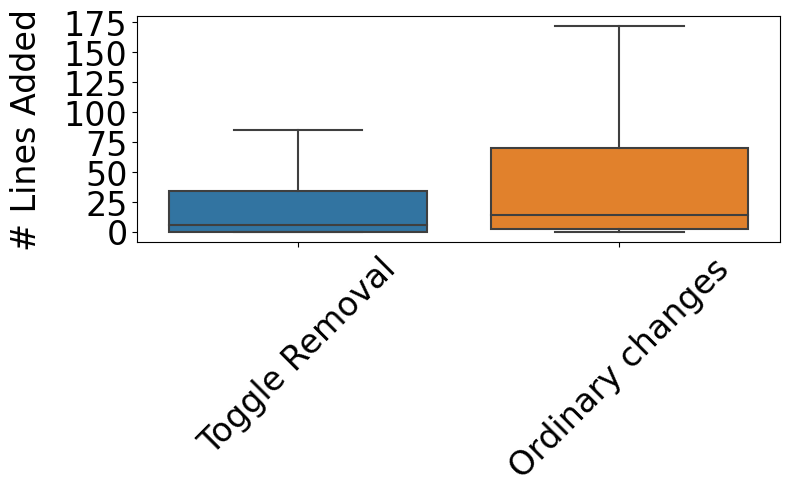

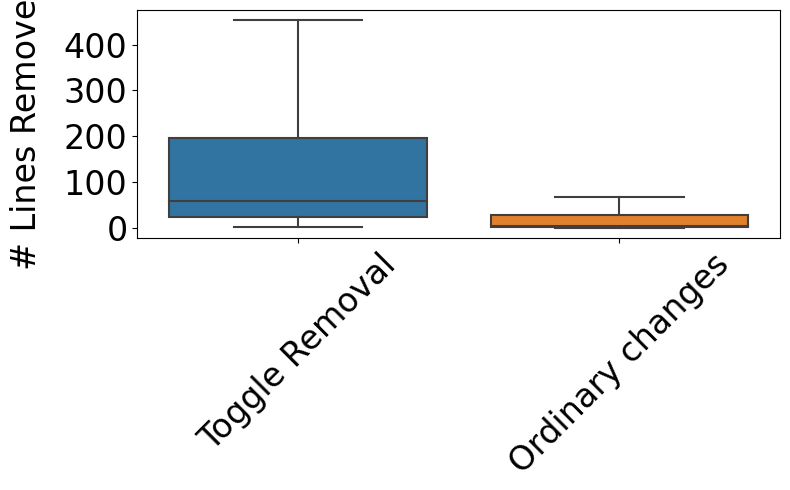

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot: Changed Files by Toggle Type (with Other)
plt.figure(figsize=(8, 5))
sns.boxplot(x='group', y='changedFiles', data=combined, showfliers=False)
plt.title("")
plt.xlabel("")
plt.ylabel("# Changed Files", fontsize=24, labelpad=15)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig('nbrefiles.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot: Additions by Toggle Type (with Other)
plt.figure(figsize=(8, 5))
sns.boxplot(x='group', y='additions', data=combined, showfliers=False)
plt.title("")
plt.xlabel("")
plt.ylabel("# Lines Added", fontsize=24, labelpad=15)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig('additions.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Plot: Removals by Toggle Type (with Other)
plt.figure(figsize=(8, 5))
sns.boxplot(x='group', y='removals', data=combined, showfliers=False)
plt.title("")
plt.xlabel("")
plt.ylabel("# Lines Removed", fontsize=24, labelpad=15)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig('removals.pdf', format='pdf', bbox_inches='tight')
plt.show()


In [17]:
from scipy.stats import mannwhitneyu

# Subsets
toggle_removal_efforts = merged[['changedFiles', 'additions', 'removals']].dropna()
other_efforts = history_non_toggle[['changedFiles', 'additions', 'removals']].dropna()

# Run Mann-Whitney U test
test_results = {}
for col in ['changedFiles', 'additions', 'removals']:
    stat, p = mannwhitneyu(
        toggle_removal_efforts[col],
        other_efforts[col],
        alternative='two-sided'
    )
    test_results[col] = {
        'U-statistic': stat,
        'p-value': p
    }

# Print results
import pprint
pprint.pprint(test_results)


{'additions': {'U-statistic': 4076852465.5, 'p-value': 1.7684060517177985e-209},
 'changedFiles': {'U-statistic': 7831025782.0, 'p-value': 0.0},
 'removals': {'U-statistic': 8491375328.0, 'p-value': 0.0}}


In [18]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Only keep removed toggles with valid lifespan
df_lifespan = df_removed[df_removed['lifecycle_days'].notna() & (df_removed['lifecycle_days'] > 0)]

# Merge with effort data on commit_id_removed
merged_lifespan = df_lifespan.merge(
    history, left_on='commit_id_removed', right_on='commit', how='inner'
)

# Keep only relevant columns
merged_lifespan = merged_lifespan[['lifecycle_days', 'changedFiles', 'removals']].dropna()

# Convert to numeric in case anything is off
merged_lifespan = merged_lifespan.apply(pd.to_numeric, errors='coerce').dropna()

#  Spearman correlation
rho_files, p_files = spearmanr(merged_lifespan['lifecycle_days'], merged_lifespan['changedFiles'])
rho_removals, p_removals = spearmanr(merged_lifespan['lifecycle_days'], merged_lifespan['removals'])

print(f"Spearman correlation (lifespan vs changed files): ρ = {rho_files:.3f}, p = {p_files:.3g}")
print(f"Spearman correlation (lifespan vs removals):      ρ = {rho_removals:.3f}, p = {p_removals:.3g}")


Spearman correlation (lifespan vs changed files): ρ = 0.016, p = 0.175
Spearman correlation (lifespan vs removals):      ρ = 0.085, p = 1.87e-12


In [21]:
import pandas as pd
import re
from collections import defaultdict

# Load file changes
with open("../../data/files_changes.txt", "r") as f:
    lines = f.read().splitlines()

# Parse the file change structure
commit_file_map = defaultdict(list)
current_commit = None
for line in lines:
    if line.startswith("---"):
        current_commit = line.strip("---")
    elif current_commit and line.strip():
        commit_file_map[current_commit].append(line.strip())


# Prepare result list
delta_results = []

# Compare added vs removed files per toggle
for _, row in df_removed.iterrows():
    commit_add = row["commit_id_added"]
    commit_rem = row["commit_id_removed"]
    
    files_added = set(commit_file_map.get(commit_add, []))
    files_removed = set(commit_file_map.get(commit_rem, []))
    
    intersection = files_added.intersection(files_removed)
    only_added = files_added - files_removed
    only_removed = files_removed - files_added
    
    delta_results.append({
        "toggle": row["variable"],
        "commit_added": commit_add,
        "commit_removed": commit_rem,
        "lifecycle_days": row['lifecycle_days'],
        "n_files_added": len(files_added),
        "n_files_removed": len(files_removed),
        "n_common_files": len(intersection),
        "n_only_added": len(only_added),
        "n_only_removed": len(only_removed),
        "pct_overlap": len(intersection) / max(len(files_added | files_removed), 1)
    })

delta_df = pd.DataFrame(delta_results)

print(delta_df['pct_overlap'].median())
print(len(delta_df[delta_df['pct_overlap'] == 1]))
print(len(delta_df[delta_df['pct_overlap'] == 1])/len(delta_df))
print(len(delta_df[delta_df['pct_overlap'] == 1]))
print(len(delta_df))

print(delta_df)

rho_files, p_files = spearmanr(delta_df['pct_overlap'], delta_df['lifecycle_days'])
print(f"Spearman correlation (lifespan vs intersection): ρ = {rho_files:.3f}, p = {p_files:.3g}")


0.25
242
0.03564589777581382
242
6789
                                 toggle  \
0               3p-intents-in-incognito   
1                     AOMAriaProperties   
2                             AOMPhase1   
3                        AbortSignalAny   
4                AbortSignalComposition   
...                                 ...   
6784      windows-scrolling-personality   
6785          windows10-custom-titlebar   
6786  wipe-data-on-child-account-signin   
6787                         xr-sandbox   
6788                   zero-state-files   

                                  commit_added  \
0     d7546ae7a656ca9919c5cac50409222a87c24e49   
1     c981cf9e41c4161516081d44a7a8944aab77ba97   
2     99db9a12afd13c2a6ad637f6dd69d550570e870a   
3     993f6cc1569f96df1fd32c67c1251b992dfd61b9   
4     c25f49cfdebeb688bd3734d3cb8c6a0a308c4d70   
...                                        ...   
6784  8baf01308b263e7ffb056a4c0750d60a216cfde1   
6785  b6d5aa8f332ad9175befe133e0a434a24381464

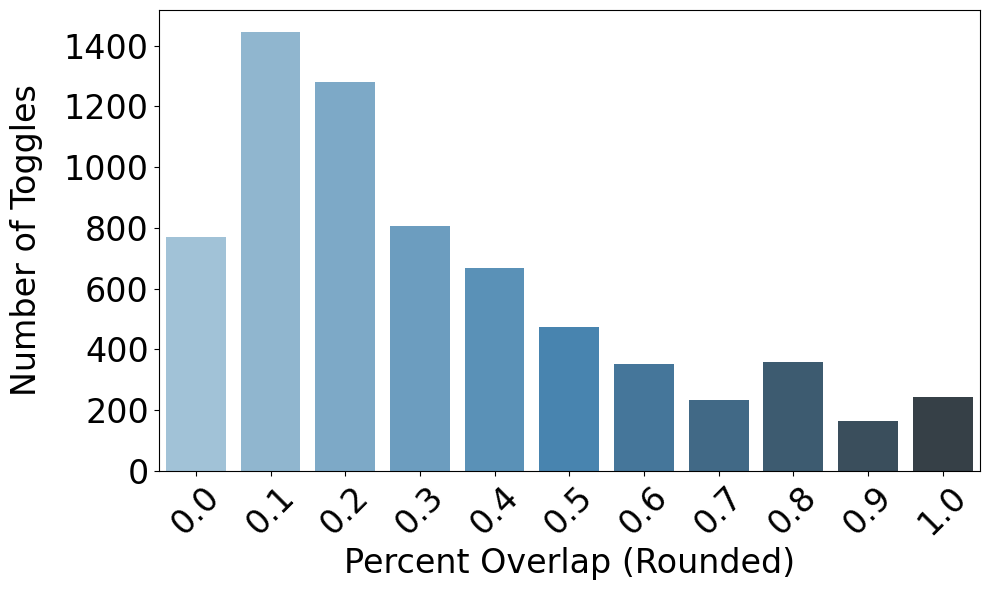

In [20]:
# Calculate the count of toggles per overlap percentage bucket
# We'll round the pct_overlap to 2 decimal places for grouping
overlap_counts = delta_df["pct_overlap"].round(1).value_counts().sort_index()

# Convert to DataFrame for plotting
overlap_df = overlap_counts.reset_index()
overlap_df.columns = ["pct_overlap", "count"]

# Plot the barplot
plt.figure(figsize=(10, 6))
sns.barplot(x="pct_overlap", y="count", data=overlap_df, palette="Blues_d")
plt.xlabel("Percent Overlap (Rounded)", fontsize=24)
plt.ylabel("Number of Toggles", fontsize=24, labelpad=15)
plt.title("")
plt.xticks(rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig('overlap.pdf', format='pdf', bbox_inches='tight')
plt.show()

